In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
from datetime import datetime, timedelta
from sklearn.metrics import r2_score
from scipy.optimize import curve_fit, fsolve

import warnings
warnings.filterwarnings("ignore")

## 1. Data Reading

In [3]:
file ='data_covid19_indonesia.csv'
df = pd.read_csv(file)
df.head()

,Date,Location ISO Code,Location,New Cases,New Deaths,New Recovered,Total Cases,Total Deaths,Total Recovered
0,3/1/2020,ID-JK,DKI Jakarta,3,0,0,3,0,0
1,3/1/2020,ID-JB,Jawa Barat,3,0,0,3,0,0
2,3/2/2020,ID-JK,DKI Jakarta,2,0,0,5,0,0
3,3/2/2020,ID-JB,Jawa Barat,0,0,0,3,0,0
4,3/2/2020,IDN,Indonesia,2,0,0,2,0,0


Berapakah jumlah data yang kita miliki?

In [4]:
df.shape

(2837, 9)

Lokasinya itu ada apa aja sih?

In [5]:
print(df['Location'].value_counts())

Jawa Barat                    104
DKI Jakarta                   104
Indonesia                     103
Banten                         99
Kalimantan Timur               91
Daerah Istimewa Yogyakarta     89
Sumatera Utara                 88
Jawa Tengah                    87
Jawa Timur                     87
Sulawesi Selatan               84
Maluku                         83
Papua                          83
Maluku Utara                   82
Sumatera Barat                 79
Sulawesi Tengah                79
Lampung                        79
Aceh                           79
Kalimantan Tengah              79
Papua Barat                    78
Sulawesi Barat                 77
Sumatera Selatan               77
Kalimantan Utara               77
Bali                           76
Riau                           76
Kalimantan Barat               76
Kepulauan Bangka Belitung      75
Kepulauan Riau                 75
Jambi                          75
Kalimantan Selatan             75
Nusa Tenggara 

### Analisis Kasus COVID-19 Skala Nasional

In [6]:
df_ina = df.where(df['Location']=='Indonesia').dropna()
df_ina = df_ina.reset_index(drop=True)
df_ina.head()

,Date,Location ISO Code,Location,New Cases,New Deaths,New Recovered,Total Cases,Total Deaths,Total Recovered
0,3/2/2020,IDN,Indonesia,2.0,0.0,0.0,2.0,0.0,0.0
1,3/3/2020,IDN,Indonesia,0.0,0.0,0.0,2.0,0.0,0.0
2,3/4/2020,IDN,Indonesia,0.0,0.0,0.0,2.0,0.0,0.0
3,3/5/2020,IDN,Indonesia,0.0,0.0,0.0,2.0,0.0,0.0
4,3/6/2020,IDN,Indonesia,2.0,0.0,0.0,4.0,0.0,0.0


In [7]:
df.tail()

,Date,Location ISO Code,Location,New Cases,New Deaths,New Recovered,Total Cases,Total Deaths,Total Recovered
2832,6/12/2020,ID-JK,DKI Jakarta,93,3,120,8244,520,3742
2833,6/12/2020,IDN,Indonesia,1111,48,577,36406,2048,13213
2834,6/12/2020,ID-MU,Maluku Utara,22,2,1,261,22,40
2835,6/12/2020,ID-JT,Jawa Tengah,44,0,50,1865,94,666
2836,6/12/2020,ID-ST,Sulawesi Tengah,0,0,0,159,4,95


## 2. Data Visualization

#### a). Visualisasi Data COVID-19 Indonesia

Pada segmen ini akan dilakukan visualisasi data untuk menunjukan kenaikan jumlah kasus positif, kematian, dan kesembuhan akibat COVID-19.

In [8]:
for i in range(len(df_ina)):
    if df_ina['Date'][i]=='6/1/2020':
        print("New Normal pada hari ke-", i)
        nw=i

New Normal pada hari ke- 91


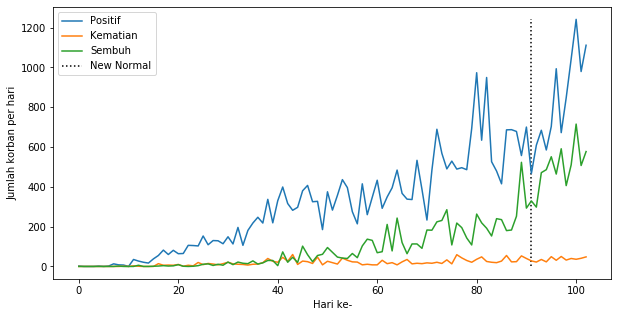

In [14]:
plt.figure(figsize=(10,5))
df_ina['New Cases'].plot(label='Positif')
df_ina['New Deaths'].plot(label='Kematian')
df_ina['New Recovered'].plot(label='Sembuh')

plt.vlines(nw, 0, max(df_ina['New Cases']), linestyles="dotted",
                     colors="k", label="New Normal")
plt.xlabel("Hari ke-")
plt.ylabel("Jumlah korban per hari")
plt.legend(loc='best')
plt.show()

## 3. Exploration Data Analysis (EDA) Pertama

Kita ingin mencoba mengetahui berapa kah kasus tertinggi, dan pada tanggal berapa kasus tertinggi itu terjadi?

In [11]:
for i in range(len(df_ina)):
    if df_ina['New Cases'].iloc[i]==df_ina['New Cases'].max():
        print("Tanggal tertinggi kasus positif covid-19 adalah", df_ina['Date'].iloc[i])
        print("Dengan jumlah", df_ina['New Cases'].iloc[i])

Tanggal tertinggi kasus positif covid-19 adalah 6/10/2020
Dengan jumlah 1241.0


In [12]:
for i in range(len(df_ina)):
    if df_ina['New Deaths'].iloc[i]==df_ina['New Deaths'].max():
        print("Tanggal tertinggi kasus kematian covid-19 adalah", df_ina['Date'].iloc[i])
        print("Dengan jumlah", df_ina['New Deaths'].iloc[i])

Tanggal tertinggi kasus kematian covid-19 adalah 4/14/2020
Dengan jumlah 60.0


In [13]:
for i in range(len(df_ina)):
    if df_ina['New Recovered'].iloc[i]==df_ina['New Recovered'].max():
        print("Tanggal tertinggi pasien sembuh covid-19 adalah", df_ina['Date'].iloc[i])
        print("Dengan jumlah", df_ina['New Recovered'].iloc[i])

Tanggal tertinggi pasien sembuh covid-19 adalah 6/10/2020
Dengan jumlah 715.0


Sekarang, kita akan mencoba membandingkan grafik kenaikan kasus covid-19 yang sedang terjadi dengan grafik sigmoid.

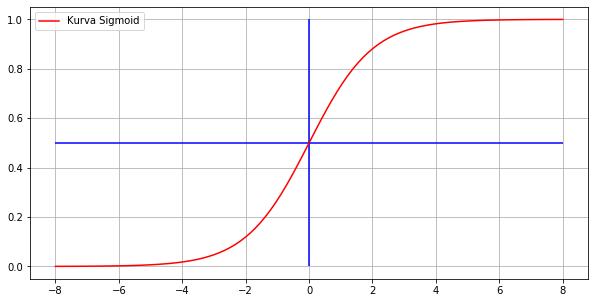

In [16]:
# Membuat Kurva Sigmoid

x=np.linspace(-8,8,100)
y=1/(1+np.exp(-x))
plt.figure(figsize=(10,5))
plt.plot(x,y, 'r', label='Kurva Sigmoid')
plt.vlines(0,0,1, 'b')
plt.hlines(0.5, -8, 8, 'b')
plt.legend()
plt.grid()
plt.show()

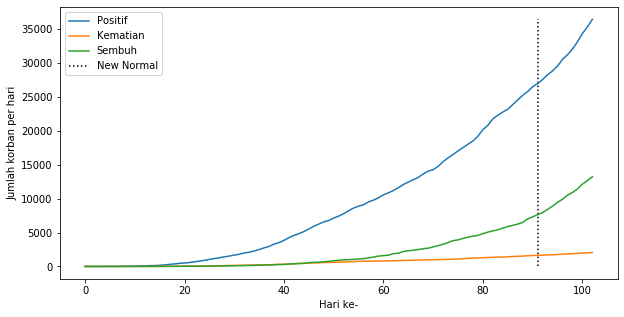

In [17]:
# Membuat kurva kenaikan kasus positif,kematian,dan juga sembuh yang sedang terjadi

plt.figure(figsize=(10,5))
df_ina['Total Cases'].plot(label='Positif')
df_ina['Total Deaths'].plot(label='Kematian')
df_ina['Total Recovered'].plot(label='Sembuh')

plt.vlines(nw, 0, max(df_ina['Total Cases']), linestyles = "dotted",
          colors = "k", label = 'New Normal')
plt.xlabel('Hari ke-')
plt.ylabel('Jumlah korban per hari')
plt.legend(loc='best')
plt.show()

Kita akan reset DataFrame di Indonesia untuk mempermudah analisis dan pembuatan data

In [18]:
df_ina.reset_index(drop=True)

,Date,Location ISO Code,Location,New Cases,New Deaths,New Recovered,Total Cases,Total Deaths,Total Recovered
0,3/2/2020,IDN,Indonesia,2.0,0.0,0.0,2.0,0.0,0.0
1,3/3/2020,IDN,Indonesia,0.0,0.0,0.0,2.0,0.0,0.0
2,3/4/2020,IDN,Indonesia,0.0,0.0,0.0,2.0,0.0,0.0
3,3/5/2020,IDN,Indonesia,0.0,0.0,0.0,2.0,0.0,0.0
4,3/6/2020,IDN,Indonesia,2.0,0.0,0.0,4.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
98,6/8/2020,IDN,Indonesia,847.0,32.0,406.0,32033.0,1883.0,10904.0
99,6/9/2020,IDN,Indonesia,1042.0,40.0,510.0,33075.0,1923.0,11414.0
100,6/10/2020,IDN,Indonesia,1241.0,36.0,715.0,34316.0,1959.0,12129.0
101,6/11/2020,IDN,Indonesia,979.0,41.0,507.0,35295.0,2000.0,12636.0


## 4. Data Modelling

Pada Segmen ini kita akan mencoba memprediksi puncak kasus COVID-19 di Indonesia dengan menggunakan model logistik, dengan rumus matematika sebagai berikut:

$$ Q_t= \frac{c}{1+e^{-1(t-t_0)/a}}$$
ada di Modul Workshop Online Python 2 halaman 63

In [28]:
def logmod (t,a,t0,c):
    return c/(1+np.exp(-(t-t0)/(a)))

In [29]:
x=list(df_ina.index)
y=list(df_ina['Total Cases'])
fit=curve_fit(logmod,x,y, method='trf')
A,B=fit

In [30]:
print(A,'dan',B)

[1.93607795e+01 8.81612768e+01 5.14122417e+04] dan [[2.45291625e-01 7.47503904e-01 9.22275845e+02]
 [7.47503904e-01 2.65406972e+00 3.31557495e+03]
 [9.22275845e+02 3.31557495e+03 4.20325735e+06]]


In [31]:
eror=np.empty(3)
for i in [0,1,2]:
    eror[i]=np.sqrt(B[i][i])
    print(eror)

[4.95269245e-01 8.81612768e+01 5.14122417e+04]
[4.95269245e-01 1.62913159e+00 5.14122417e+04]
[4.95269245e-01 1.62913159e+00 2.05018471e+03]


In [32]:
a = A[0]+eror[0]
t0 = A[1]+eror[1]
c = A[2]+eror[2]

In [33]:
def puncak(x):
    return logmod(x,a,t0,c)-int(c)

In [34]:
n_puncak=int(fsolve(puncak,t0))
print("Hari puncak wabah COVID-19 adalah",n_puncak)

Hari puncak wabah COVID-19 adalah 322


In [35]:
n_0=max(x)+1
pred_x=list(range(n_0,n_puncak))

In [36]:
print("Kita memiliki",len(pred_x),"hari menuju puncak wabah")

Kita memiliki 219 hari menuju puncak wabah


In [38]:
pred_y=np.zeros(len(x+pred_x))
for i in range(n_puncak):
    pred_y[i]=logmod(i,a,t0,c)
    
print("Prediksi jumlah puncak ada", int(pred_y[-1]),"orang")

Prediksi jumlah puncak ada 53461 orang


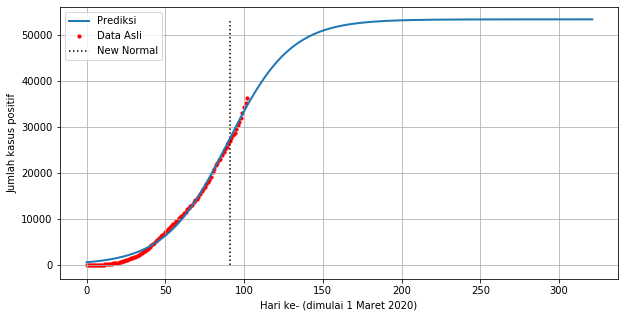

In [39]:
plt.figure(figsize=(10,5))
plt.plot(x+pred_x,pred_y,linewidth=2.0,label='Prediksi')
plt.scatter(x,y, label='Data Asli',s=10,color='red')
plt.vlines(nw, 0, max(pred_y),linestyles="dotted",
          colors="k",label='New Normal')
plt.xlabel('Hari ke- (dimulai 1 Maret 2020)')
plt.ylabel('Jumlah kasus positif')
plt.grid()
plt.legend(loc='best')
plt.show()

Sekarang kita akan mencoba untuk mengevaluasi bentuk kurva prediksi menggunakan r2_score.

In [43]:
s1=(np.subtract(y,pred_y[0:max(df_ina.index)+1])**2).sum()
s2=(np.subtract(y,np.mean(y))**2).sum()
r=1-s1/s2

In [44]:
print("Skor yang diperoleh adalah", round(r,5)*100,"%")

Skor yang diperoleh adalah 99.559 %


Menghitung prediksi tanggal puncak COVID-19 di Indonesia

In [47]:
fmt='%m/%d/%Y'
nw0='6/1/2020'
tgl_0=datetime.strptime(nw0,fmt)
tgl_puncak=tgl_0+timedelta(days=n_puncak-nw)
h_puncak=tgl_puncak.strftime(fmt)

In [48]:
print("Puncak jumlah kasus COVID-19 di Indonesia", int(c),"orang.")
print("Puncak wabah COVID-19 di Indonesia adalah",n_puncak-nw,
     "hari setelah New Normal",nw0)
print("Jatuh pada tanggal",h_puncak)

Puncak jumlah kasus COVID-19 di Indonesia 53462 orang.
Puncak wabah COVID-19 di Indonesia adalah 231 hari setelah New Normal 6/1/2020
Jatuh pada tanggal 01/18/2021


In [49]:
df_ina['Prediksi Positif']=pred_y[0:103].astype(int)
df_ina.tail(10)

,Date,Location ISO Code,Location,New Cases,New Deaths,New Recovered,Total Cases,Total Deaths,Total Recovered,Prediksi Positif
93,6/3/2020,IDN,Indonesia,684.0,35.0,471.0,28233.0,1698.0,8406.0,28886
94,6/4/2020,IDN,Indonesia,585.0,23.0,486.0,28818.0,1721.0,8892.0,29554
95,6/5/2020,IDN,Indonesia,703.0,49.0,551.0,29521.0,1770.0,9443.0,30217
96,6/6/2020,IDN,Indonesia,993.0,31.0,464.0,30514.0,1801.0,9907.0,30877
97,6/7/2020,IDN,Indonesia,672.0,50.0,591.0,31186.0,1851.0,10498.0,31531
98,6/8/2020,IDN,Indonesia,847.0,32.0,406.0,32033.0,1883.0,10904.0,32179
99,6/9/2020,IDN,Indonesia,1042.0,40.0,510.0,33075.0,1923.0,11414.0,32821
100,6/10/2020,IDN,Indonesia,1241.0,36.0,715.0,34316.0,1959.0,12129.0,33456
101,6/11/2020,IDN,Indonesia,979.0,41.0,507.0,35295.0,2000.0,12636.0,34082
102,6/12/2020,IDN,Indonesia,1111.0,48.0,577.0,36406.0,2048.0,13213.0,34700


##### Analisis Setiap Provinsi

In [50]:
for i in range(len(df)):
    if df.Location[i]=='Indonesia':
        df=df.drop([i])

In [51]:
del df['Location ISO Code']

In [52]:
df=df.set_index(['Location'])

In [54]:
df['hari']=df['Date'].map(lambda x : (datetime.strptime(
x,'%m/%d/%Y')-datetime.strptime('3/1/2020','%m/%d/%Y')).days)

In [55]:
df.tail()

,Date,New Cases,New Deaths,New Recovered,Total Cases,Total Deaths,Total Recovered,hari
Location,,,,,,,,
Sulawesi Tenggara,6/12/2020,5,0,2,272,5,180,103
DKI Jakarta,6/12/2020,93,3,120,8244,520,3742,103
Maluku Utara,6/12/2020,22,2,1,261,22,40,103
Jawa Tengah,6/12/2020,44,0,50,1865,94,666,103
Sulawesi Tengah,6/12/2020,0,0,0,159,4,95,103


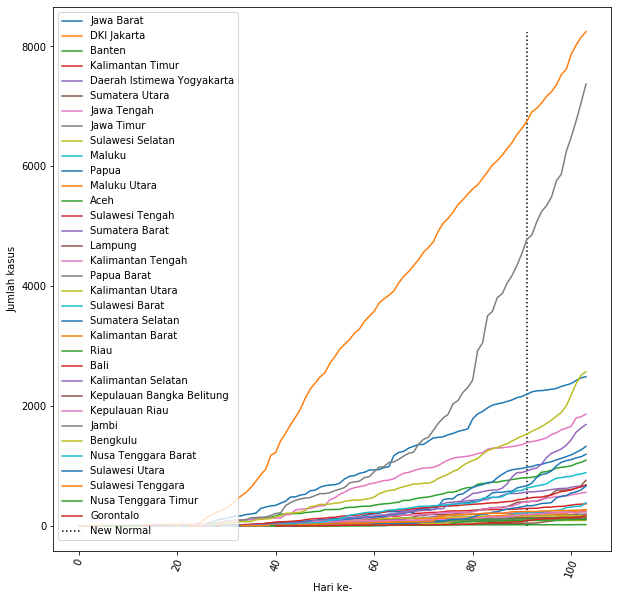

In [58]:
nm_prov=df.index.value_counts().index
plt.figure(figsize=(10,10))
for i in nm_prov:
    plt.plot(df.loc[i]['hari'],
            df.loc[i]['Total Cases'], label=i)
plt.vlines(nw,0,max(df['Total Cases']), linestyles = "dotted",
              colors="k", label="New Normal")
plt.legend(loc='best')
plt.xticks(rotation=70)
plt.xlabel('Hari ke-')
plt.ylabel('Jumlah kasus')
plt.show()

Pada pelatihan kali ini, kita akan mencoba menganlisis lima daerah tertinggi yang terkena kasus COVID-19. 

Kita juga bisa melakukan analisis untuk daerah manapun untuk melihat apakah sebuah provinsi sudah menuju puncak COVID atau belum.

In [60]:
cat_nw=np.empty(len(df.hari), dtype='object')
nn_kas=np.zeros(len(df.hari))
for i in range(len(df.hari)):
    if df['Date'][i]=='6/1/2020':
        cat_nw[i]=df.iloc[i].name
        nn_kas[i]=df.iloc[i]['Total Cases']

In [61]:
cat_nw=cat_nw[cat_nw != np.array(None)]
nn_kas=nn_kas[nn_kas != np.array(0)]

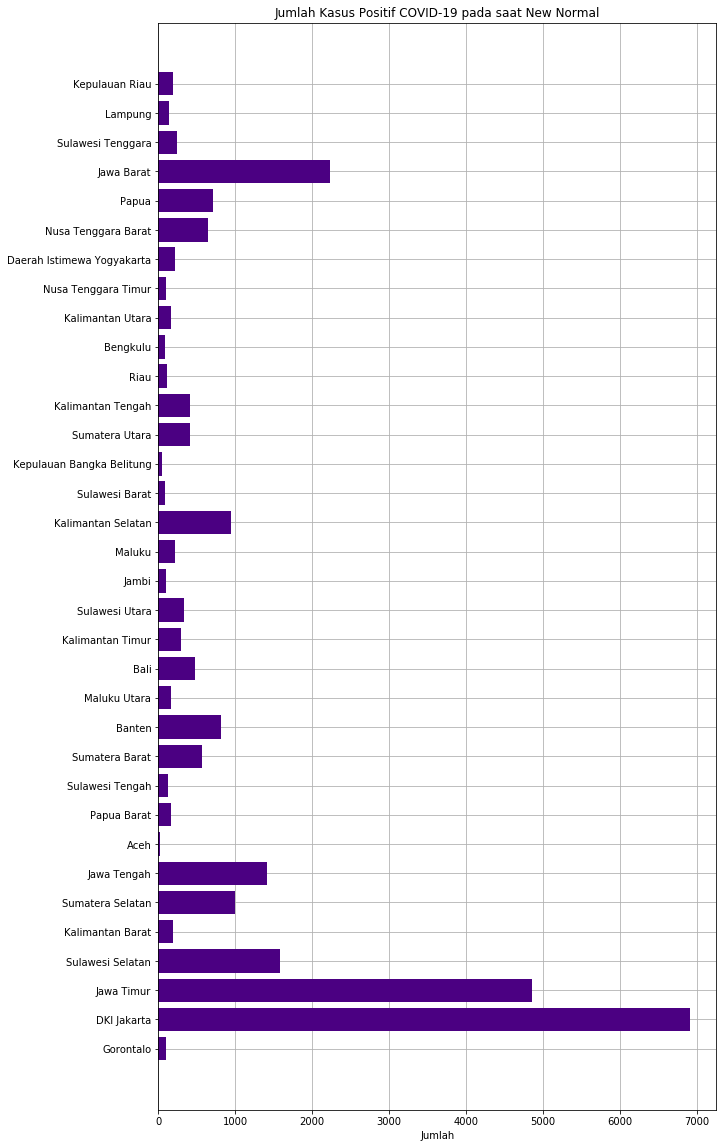

In [62]:
x=np.arange(len(cat_nw))
plt.figure(figsize=(10,20))
plt.title('Jumlah Kasus Positif COVID-19 pada saat New Normal')
plt.barh(x,nn_kas,align='center',
        color='indigo',zorder=2)
plt.yticks(x,cat_nw)
plt.xlabel('Jumlah')
plt.grid()
plt.show()

In [63]:
totkas=np.zeros(len(cat_nw))
for i in range(len(cat_nw)):
    totkas[i]=df.loc[cat_nw[i]]['Total Cases'][-1]

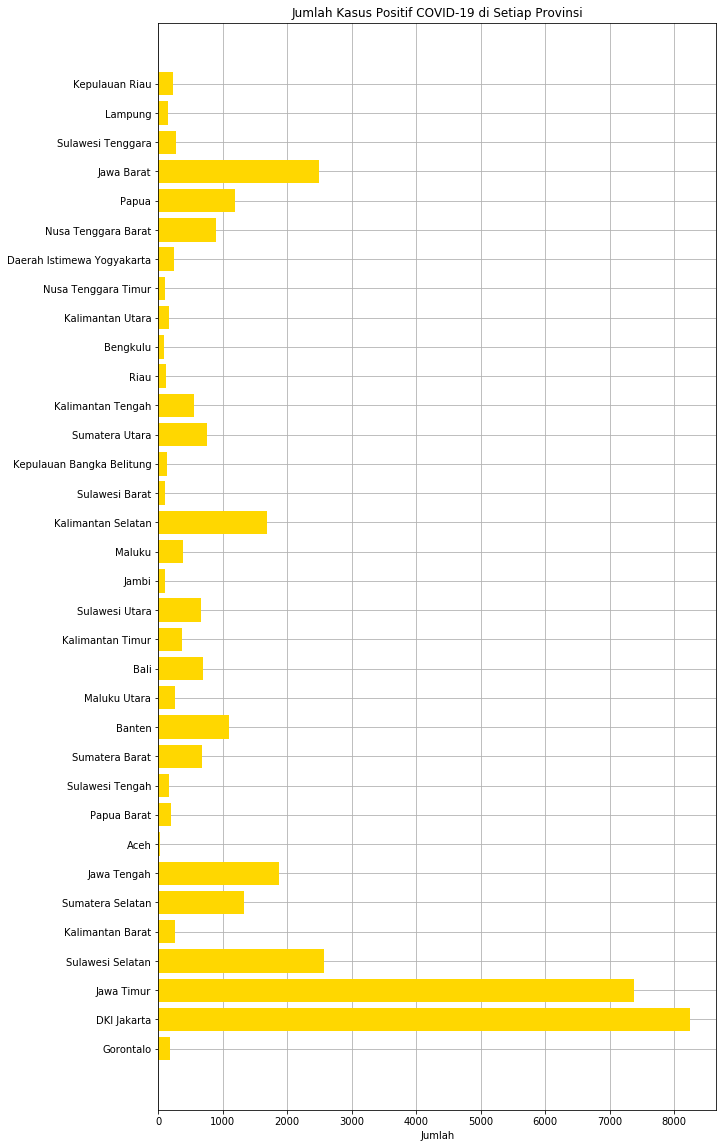

In [64]:
x=np.arange(len(cat_nw))
plt.figure(figsize=(10,20))
plt.title('Jumlah Kasus Positif COVID-19 di Setiap Provinsi')
plt.barh(x,totkas,align='center',
        color='gold',zorder=2)
plt.yticks(x,cat_nw)
plt.xlabel('Jumlah')
plt.grid()
plt.show()

In [65]:
data={'Lokasi':cat_nw, 'Total':totkas}
dt_gt=pd.DataFrame(data)
dt_gt=dt_gt.sort_values(by=['Total'])
dt_gt.head()

,Lokasi,Total
7,Aceh,22.0
24,Bengkulu,95.0
19,Sulawesi Barat,97.0
16,Jambi,105.0
26,Nusa Tenggara Timur,105.0


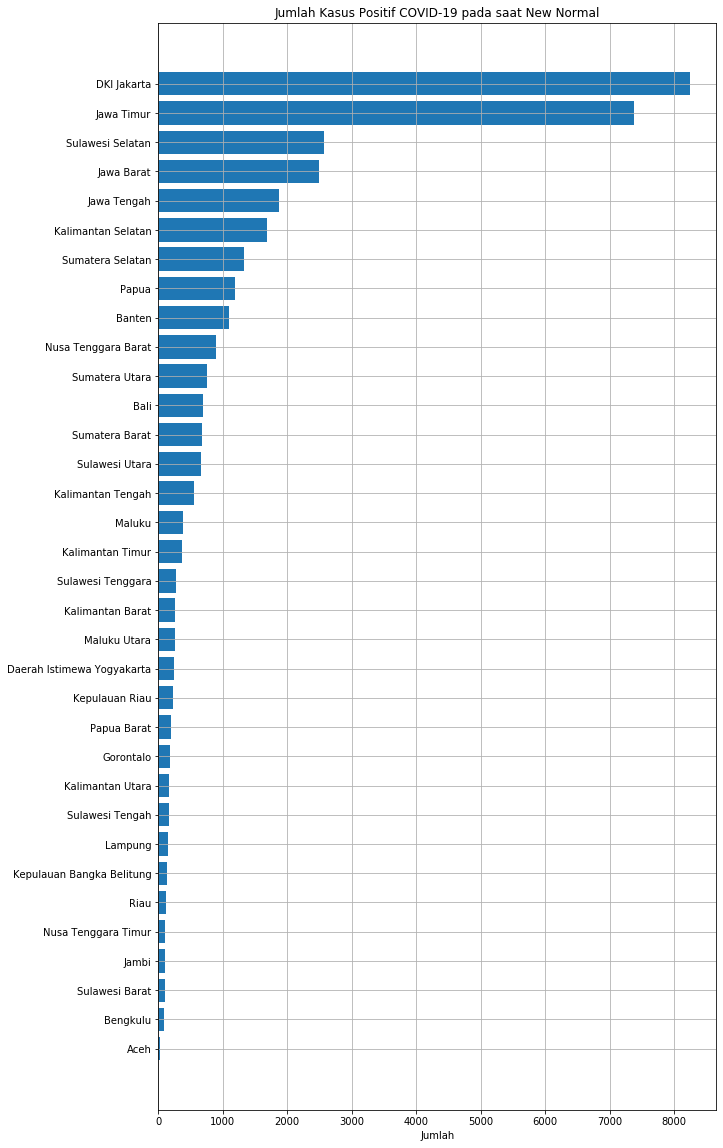

In [66]:
x=np.arange(len(cat_nw))
plt.figure(figsize=(10,20))
plt.title('Jumlah Kasus Positif COVID-19 pada saat New Normal')
plt.barh(x,dt_gt['Total'])
plt.yticks(x,dt_gt['Lokasi'])
plt.xlabel('Jumlah')
plt.grid()
plt.show()

Sekarang kita akan ambil 3 lokasi terbesar dan terkecil untuk kita olah lebih lanjut, serta kita jadikan satu data.

In [67]:
max_3=dt_gt['Lokasi'].tail(3).to_numpy(str)

In [68]:
print("Tiga provinsi terbanyak kasus COVID-19", max_3)

Tiga provinsi terbanyak kasus COVID-19 ['Sulawesi Selatan' 'Jawa Timur' 'DKI Jakarta']


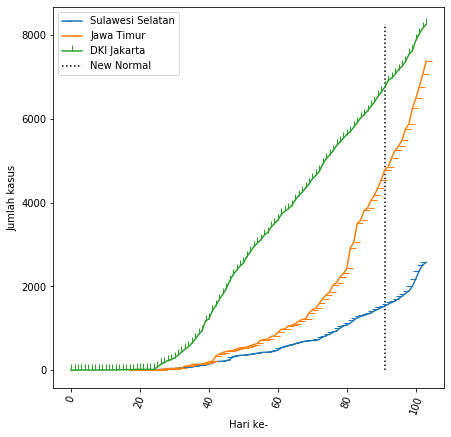

In [69]:
plt.figure(figsize=(7,7))
for idx, i in enumerate(max_3):
    plt.plot(df.loc[i]['hari'],
            df.loc[i]['Total Cases'], label=i, marker=idx)
plt.vlines(nw, 0, max(df['Total Cases']), linestyles = "dotted",
          colors="k", label="New Normal")
plt.legend(loc='best')
plt.xticks(rotation=70)
plt.xlabel('Hari ke-')
plt.ylabel('Jumlah kasus')
plt.show()

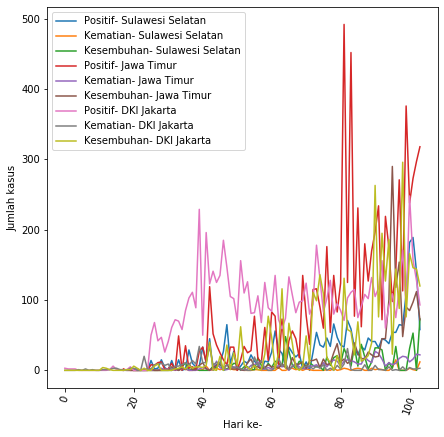

In [71]:
plt.figure(figsize=(7,7))
for i in max_3:
    plt.plot(df.loc[i]['hari'], df.loc[i]['New Cases'],
            label="Positif- "+i)
    plt.plot(df.loc[i]['hari'], df.loc[i]['New Deaths'],
            label="Kematian- "+i)
    plt.plot(df.loc[i]['hari'], df.loc[i]['New Recovered'],
            label="Kesembuhan- "+i)
plt.legend(loc='best')
plt.xticks(rotation=70)
plt.xlabel('Hari ke-')
plt.ylabel('Jumlah kasus')
plt.show()

Pada segmen ini, kita akan membagi data untuk sumbu-x dan sumbu-y. Nilai sumbu-y ada tiga, karena mewakili untuk setiap daerah (provinsi). Nilai-nilai pada sumbu-x adalah variabel bebas yang mempengaruhi hasil untuk nilai sumbu-y. Kita hanya akan menggunakan data dari kasus positif, karena semua data meninggal dan sembuh dimulai dari penambahan kasus positif pada korban.

In [72]:
# pembagian data untuk propinsi DKI Jakarta
y_dki=list(df.loc['DKI Jakarta']['Total Cases'])
x_dki=list(range(len(y_dki)))
fit_dki=curve_fit(logmod,x_dki,y_dki)
A1,B1=fit_dki

# pembagian data untuk propinsi Jawa Timur
y_jt=list(df.loc['Jawa Timur']['Total Cases'])
x_jt=list(range(len(y_jt)))
fit_jt=curve_fit(logmod,x_jt,y_jt)
A2,B2=fit_jt

# pembagian data untuk propinsi Sulawesi Selatan
y_ss=list(df.loc['Sulawesi Selatan']['Total Cases'])
x_ss=list(range(len(y_ss)))
fit_ss=curve_fit(logmod,x_ss,y_ss)
A3,B3=fit_ss

In [73]:
eror1=eror2=eror3=np.empty(3)
for i in [0,1,2]:
    eror1[i]=np.sqrt(B1[i][i])
    eror2[i]=np.sqrt(B2[i][i])
    eror3[i]=np.sqrt(B3[i][i])

In [78]:
a1=A1[0]+eror1[0]
t01=A1[1]+eror1[1]
c1=A1[2]+eror1[2]

a2=A2[0]+eror2[0]
t02=A2[1]+eror2[1]
c2=A2[2]+eror2[2]

a3=A3[0]+eror3[0]
t03=A3[1]+eror3[1]
c3=A3[2]+eror3[2]

In [79]:
def puncak1(x):
    return logmod(x,a1,t01,c1)-int(c1)

def puncak2(x):
    return logmod(x,a2,t02,c2)-int(c2)

def puncak3(x):
    return logmod(x,a3,t03,c3)-int(c3)

In [80]:
n_puncak1=int(fsolve(puncak1,t01))
n_puncak2=int(fsolve(puncak2,t02))
n_puncak3=int(fsolve(puncak3,t03))

print("Hari puncak wabah COVID-19 di DKI Jakarta adalah",n_puncak1)
print("Hari puncak wabah COVID-19 di Jawa Timur adalah",n_puncak2)
print("Hari puncak wabah COVID-19 di Sulawesi Selatan adalah",n_puncak3)

Hari puncak wabah COVID-19 di DKI Jakarta adalah 253
Hari puncak wabah COVID-19 di Jawa Timur adalah 267
Hari puncak wabah COVID-19 di Sulawesi Selatan adalah 346


In [81]:
n_0_dki=max(x_dki)+1
n_0_jt=max(x_jt)+1
n_0_ss=max(x_ss)+1

pred_x1=list(range(n_0_dki,n_puncak1))
pred_x2=list(range(n_0_jt,n_puncak2))
pred_x3=list(range(n_0_ss,n_puncak3))

In [82]:
print("DKI Jakarta memiliki", len(pred_x1),"hari lagi menuju puncak wabah")
print("Jawa Timur memiliki", len(pred_x2),"hari lagi menuju puncak wabah")
print("Sulawesi Selatan memiliki", len(pred_x3),"hari lagi menuju puncak wabah")

DKI Jakarta memiliki 149 hari lagi menuju puncak wabah
Jawa Timur memiliki 180 hari lagi menuju puncak wabah
Sulawesi Selatan memiliki 262 hari lagi menuju puncak wabah


In [84]:
pred_y1=np.zeros(len(x_dki+pred_x1))
for i in range(n_puncak1):
    pred_y1[i]=logmod(i,a1,t01,c1)
    
pred_y2=np.zeros(len(x_jt+pred_x2))
for i in range(n_puncak2):
    pred_y2[i]=logmod(i,a2,t02,c2)

pred_y3=np.zeros(len(x_ss+pred_x3))
for i in range(n_puncak3):
    pred_y3[i]=logmod(i,a3,t03,c3)

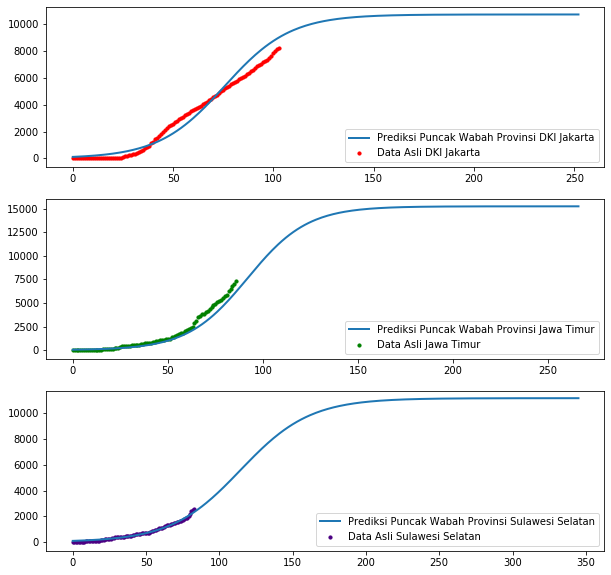

In [88]:
plt.figure(figsize=(10,10))
plt.subplot(3,1,1)

#ilustrasi kurva puncak wabah propinsi DKI Jakarta
plt.plot(x_dki+pred_x1,pred_y1,linewidth=2.0,
        label='Prediksi Puncak Wabah Provinsi DKI Jakarta')
plt.scatter(x_dki,y_dki, label='Data Asli DKI Jakarta', s=10,
            color='red')
plt.legend(loc='best')

#ilustrasi kurva puncak wabah propinsi Jawa Timur
plt.subplot(3,1,2)
plt.plot(x_jt+pred_x2,pred_y2,linewidth=2.0,
        label='Prediksi Puncak Wabah Provinsi Jawa Timur')
plt.scatter(x_jt,y_jt, label='Data Asli Jawa Timur', s=10,
            color='green')
plt.legend(loc='best')

#ilustrasi kurva puncak wabah propinsi Sulawesi Selatan
plt.subplot(3,1,3)
plt.plot(x_ss+pred_x3,pred_y3,linewidth=2.0,
        label='Prediksi Puncak Wabah Provinsi Sulawesi Selatan')
plt.scatter(x_ss,y_ss, label='Data Asli Sulawesi Selatan', s=10,
            color='indigo')
plt.legend(loc='best')

plt.show()

In [89]:
from sklearn.metrics import r2_score

In [90]:
R1=r2_score(y_dki, pred_y1[1:len(y_dki)+1])
R2=r2_score(y_jt, pred_y2[1:len(y_jt)+1])
R3=r2_score(y_ss, pred_y3[1:len(y_ss)+1])

In [94]:
print("Skor prediksi di Provinsi DKI Jakarta",
     round(R1,5)*100,"%")
print("Skor prediksi di Provinsi Jawa Timur",
     round(R2,5)*100,"%")
print("Skor prediksi di Provinsi Sulawesi Selatan",
     round(R3,5)*100,"%")

Skor prediksi di Provinsi DKI Jakarta 95.3 %
Skor prediksi di Provinsi Jawa Timur 95.918 %
Skor prediksi di Provinsi Sulawesi Selatan 98.895 %


Sekarang kita akan memasuki bagian final pada modelling untuk data science kali ini. Kita akan mencoba memprediksi tanggal puncak COVID-19 di 3 Provinsi yang telah kita analisis (DKI Jakarta, Jawa Timur, Sulawesi Selatan).

In [95]:
#prediksi tanggal puncak wabah di propinsi DKI Jakarta
tgl_puncak1=tgl_0+timedelta(days=n_puncak1)
h_puncak1=tgl_puncak1.strftime(fmt)

#prediksi tanggal puncak wabah di propinsi Jawa Timur
tgl_puncak2=tgl_0+timedelta(days=n_puncak2)
h_puncak2=tgl_puncak2.strftime(fmt)

#prediksi tanggal puncak wabah di propinsi Sulawesi Selatan
tgl_puncak3=tgl_0+timedelta(days=n_puncak3)
h_puncak3=tgl_puncak3.strftime(fmt)

## 5. Data Science Final Result

In [97]:
#propinsi DKI Jakarta
print("Puncak jumlah kasus di DKI Jakarta", int(c1),"orang.")
print("Puncak wabah adalah",n_puncak1,"hari lagi.")
print("Jatuh pada tanggal", h_puncak1)
print("Dengan score", round(R1,5)*100,"%")

Puncak jumlah kasus di DKI Jakarta 10749 orang.
Puncak wabah adalah 253 hari lagi.
Jatuh pada tanggal 02/09/2021
Dengan score 95.3 %


In [98]:
#propinsi Jawa Timur
print("Puncak jumlah kasus Jawa Timur", int(c2),"orang.")
print("Puncak wabah adalah",n_puncak2,"hari lagi.")
print("Jatuh pada tanggal", h_puncak2)
print("Dengan score", round(R2,5)*100,"%")

Puncak jumlah kasus Jawa Timur 15250 orang.
Puncak wabah adalah 267 hari lagi.
Jatuh pada tanggal 02/23/2021
Dengan score 95.918 %


In [99]:
#propinsi Sulawesi Selatan
print("Puncak jumlah kasus di DKI Jakarta", int(c3),"orang.")
print("Puncak wabah adalah",n_puncak3,"hari lagi.")
print("Jatuh pada tanggal", h_puncak3)
print("Dengan score", round(R3,5)*100,"%")

Puncak jumlah kasus di DKI Jakarta 11182 orang.
Puncak wabah adalah 346 hari lagi.
Jatuh pada tanggal 05/13/2021
Dengan score 98.895 %
